In [ ]:
from google.colab import files
upload = files.upload()

Saving vgames2.csv to vgames2 (1).csv


# Import data file and Check the shape

- 데이터를 읽는다.
- 컬럼명을 확인하고 불필요한 컬럼을 drop시킨다.
- 컬럼별 데이터 타입을 확인한다.
- 중복된 record를 drop시킨다.

In [ ]:
import pandas as pd

df = pd.read_csv("/content/vgames2.csv")
print(df.shape)
# print(df.columns)   # Index(['Unnamed: 0', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], dtype='object')
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop_duplicates()
df = df.reset_index(drop=True)
# print(df.columns)   # Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], dtype='object')
# print(df.dtypes)   # ['Name' : 'object', 'Platform' : 'object', 'Year' : 'float64', 'Genre' : 'object', 'Publisher' : 'object', 'NA_Sales' : 'object', 'EU_Sales' : 'object', 'JP_Sales' : 'object', 'Other_Sales' : 'object'] dtype: object

(16598, 10)


# 'Year' column
---
## Handling the format of the vlaue & missing values
1. 출시년도에 해당하는 'Year'columnn의 Missing values가 271개 존재
  - 'Platform'을 알면 대략적인 대략적인 출시년도를 알 수 있을 것이라 판단(Platform이 단순 제조사가 아닌 세대별로 구분이 되어있기 때문)
  - 'Platform'column에는 Missing values가 존재하지 않음
  - 신뢰할 수 있는 값을 가진 rows을 'Platform'별로 그룹화하여 평균값을 계산
  - Missing value가 있는 row의 'Platform'을 확인하고 해당하는 평균값으로 대체
2. 네자리가 아닌 한자리 또는 두자리 숫자로 출시년도가 표시된 경우
 - 한자리 또는 두자리 숫자에 1900, 2000을 더한 후에 각 'Platform'별 평균 출시년도와 가까운 숫자를 선택
3. 2016년 이후의 데이터가 존재
 - 2016년까지의 데이터이므로 'Platform'을 확인하고 해당하는 평균값으로 대체

In [ ]:
import numpy as np   # np.isnan()

# print(df['Year'].unique())
# print(df['Year'].isna().sum())   # 271

df_4_year = df[(df['Year']>1000)]   # 신뢰할 수 있는 'Year'값을 가진 row만 추출
df_4_year = df_4_year.reset_index(drop=True)
mean_year = df_4_year.groupby('Platform').mean()   # 'Platform'에 따른 'Year'값의 평균

for i in range(len(df)):   # Checking each value of column 'Year' 
  if np.isnan(df['Year'][i]):   # Missing value인 경우
    df['Year'][i] = round(mean_year['Year'][df['Platform'][i]])
  elif df['Year'][i] < 1000:   # 자리수가 4자리가 아닌경우
    # 해당하는 'Platform'의 평균 출시년도가 value에 1900을 더한것과 2000을 더한것중 어느쪽에 더 가까운 지 확인 후 값 대체
    if abs((df['Year'][i]+1900)-mean_year['Year'][df['Platform'][i]]) < abs((df['Year'][i]+2000)-mean_year['Year'][df['Platform'][i]]):
      df['Year'][i] += 1900
    else:
      df['Year'][i] += 2000
  elif df['Year'][i] > 2016:   # 2016 이후의 데이터인 경우
    df['Year'][i] = round(mean_year['Year'][df['Platform'][i]])

# print(df['Year'].unique())
# print(df['Year'].isna().sum())   # 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

# 'Genre', 'Publisher' column
---
## Handling the format of the vlaue
1. 각각 50, 58개의 Missing values 존재
 - string값의 특성상 평균값과 같은 통계치를 이용할 수 없어 추정이 어려움
 - 'Name' column의 value를 통해 하나씩 검색할 수 있지만 비용이 큼
 - 따라서 'Genre', 'Publisher' column에서 결측치가 존재하는 row는 drop

In [ ]:
# print(df['Genre'].unique())
# print(df['Genre'].isna().sum())
# print(df['Publisher'].unique())
# print(df['Publisher'].isna().sum())
df = df.dropna(subset=['Genre', 'Publisher'])
df = df.reset_index(drop=True)

# 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales' column
---
## Handling the format
1. 숫자 뒤에 'K' 또는 'M'이 붙은 경우, 숫자만 있는 경우 혼재
 - 단위는 'M'에 맞추고, 'K', 'M'과 같은 문자는 제거
 - 각 column별 자료형 지정

In [ ]:
# Handling the format
def format_value(col):
  for i in range(len(df)):
    if type(df[col][i]) != str:
      continue
    else:
      if 'K' in df[col][i]:
        df[col][i] = float(df[col][i][:-1])/1000.0
      elif 'M' in df[col][i]:
        df[col][i] = float(df[col][i][:-1])
      else:
        df[col][i] = float(df[col][i])

format_value('NA_Sales')
format_value('EU_Sales')
format_value('JP_Sales')
format_value('Other_Sales')

df = df.astype({'Name' : 'string', 'Platform' : 'string', 'Year' : 'int', 'Genre' : 'string', 'Publisher' : 'string', 'NA_Sales' : 'float', 'EU_Sales' : 'float', 'JP_Sales' : 'float', 'Other_Sales' : 'float'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# 질문
---
1. 지역에 따라서 선호하는 게임 장르가 다를까?
 - bar plot으로 grouping(facet)을 사용
 - df를 'Genre'별로 group화

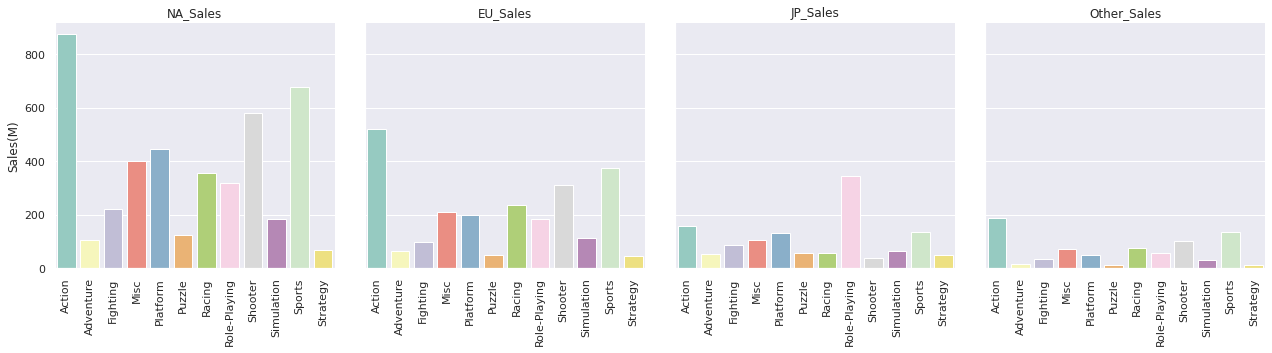

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

df_by_genre = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].groupby('Genre').sum()   # 'Genre'별로 그룹화한 후 각 Sales값의 합계
df_by_genre = df_by_genre.reset_index(drop=False)
melt_df_by_genre = df_by_genre.melt(id_vars=["Genre"], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], var_name="Region", value_name="Sales")   # FacetGrid를 그리기위해 wide -> tidy
g = sns.FacetGrid(melt_df_by_genre, col="Region", height=4.5)
g.map(sns.barplot, "Genre", "Sales", palette="Set3", order=list(df_by_genre['Genre'].unique()))
g.set_axis_labels("", "Sales(M)")
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90);
plt.show()

 - 전세계 선호하는 게임 Top3와 판매량?
 - 지역에 따라서 선호하는 게임 Top3와 판매량?

In [ ]:
def print_top(col, top):
  col_top = w_df_by_genre[['Genre', col]].nlargest(n=top, columns=col).reset_index(drop=True)
  name = {'NA_Sales':'North America', 'EU_Sales':'Europe', 'JP_Sales':'Japan', 'Other_Sales':'Others', 'World_Sales':'World'}
  print('\n{:*^40}'.format(" Top%d Genre in %s " % (top, name[col])))
  for i in range(top):
    print('#{0} {1:^17} - {2:>12.2f}M'.format(i+1, col_top['Genre'][i], col_top[col][i]))

w_df_by_genre = df_by_genre.copy()
w_df_by_genre['World_Sales'] = w_df_by_genre.sum(axis=1)   # 장르별 전세계 판매량을 추가한 DataFrame

print_top('World_Sales',3)
print_top('NA_Sales',3)
print_top('EU_Sales',3)
print_top('JP_Sales',3)
print_top('Other_Sales',3)


********* Top3 Genre in World **********
#1      Action       -      1740.46M
#2      Sports       -      1325.46M
#3      Shooter      -      1035.84M

***** Top3 Genre in North America ******
#1      Action       -       874.52M
#2      Sports       -       679.71M
#3      Shooter      -       581.91M

********* Top3 Genre in Europe *********
#1      Action       -       522.08M
#2      Sports       -       375.93M
#3      Shooter      -       313.02M

********* Top3 Genre in Japan **********
#1   Role-Playing    -       344.90M
#2      Action       -       157.44M
#3      Sports       -       135.25M

********* Top3 Genre in Others *********
#1      Action       -       186.42M
#2      Sports       -       134.57M
#3      Shooter      -       102.65M


 - 그래서, 통계적으로 지역에 따른 게임 장르 선호도가 다를까?
  - Chi square test
  - H0 : 두 변수(지역과 판매량)는 독립적이다. (independence) (선호도가 같다.)
  - Ha : 두 변수(지역과 판매량)는 독립적이지 않다. (related) (선호도가 같지 않다.)
  - α : 0.05

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

obs = np.array(df_by_genre[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]).T
g, p, dof, expctd = chi2_contingency(obs)
if p < 0.05:
  print("Reject the Null hypothesis!")
  print("통계적으로 지역에 따른 게임 장르 선호도는 유의하다.(같지 않다.)")
else:
  print("Failure to reject the Null hypothesis!")
  print("통계적으로 지역에 따른 게임 장르 선호도는 유의하지 않다.(같다.)")

Reject the Null hypothesis!
통계적으로 지역에 따른 게임 장르 선호도는 유의하다.(같지 않다.)


2. 연도별 게임 트렌드가 있을까?
 - 주어진 데이터만으로는 연도별 'Genre'에따른 판매량을 알 수가 없음
 - 따라서, 연도별 'Genre'에따른 출시된 게임의 수를 통해 비교

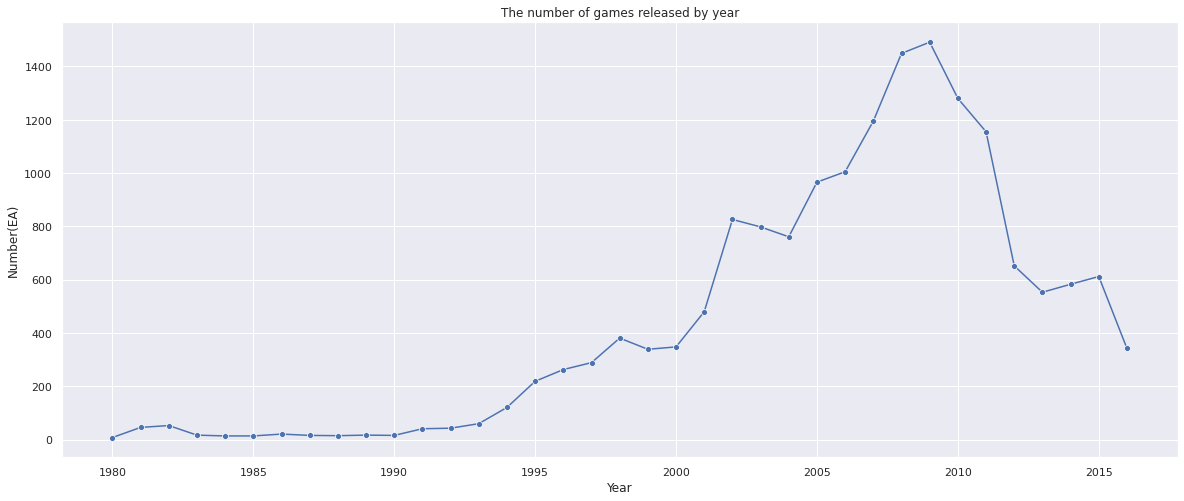

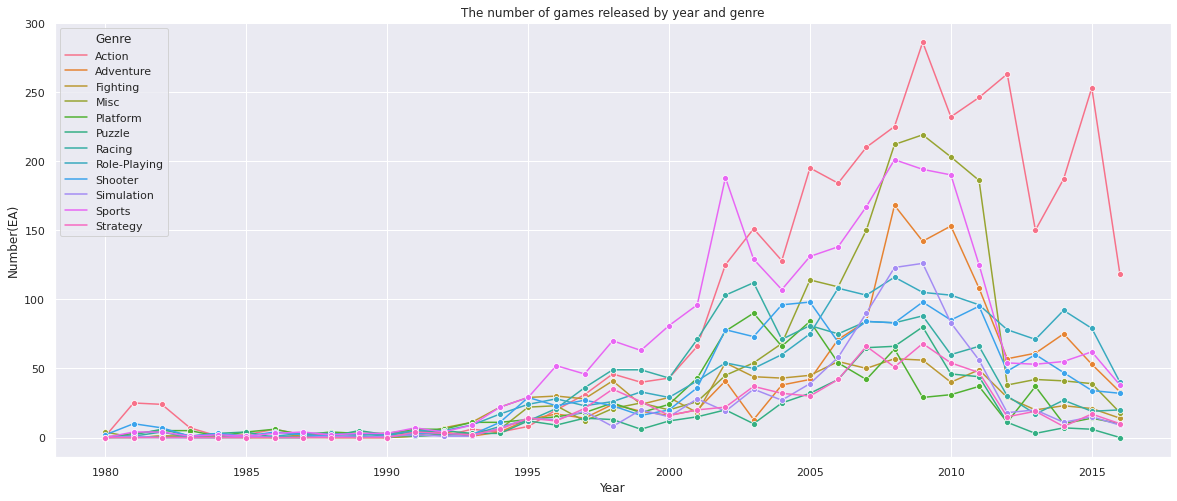

In [ ]:
df_by_year = df[['Name', 'Year', 'Genre']].groupby(['Year','Genre']).count()
df_by_year = df_by_year.reset_index(drop=False)

df_by_year_wide = df_by_year.pivot("Year", "Genre", "Name")   # tidy -> wide
df_by_year_wide = df_by_year_wide.fillna(0)   # Missing values 0으로 대체
df_by_year_wide = df_by_year_wide.reset_index(drop=False)

for col in list(df['Genre'].unique()):   # "Genre"별로 반복하면서 datatype을 int로 변환
    df_by_year_wide[col] = df_by_year_wide[col].astype('int')

df_by_year = df_by_year_wide.melt(id_vars=["Year"], var_name="Genre", value_name="Number")   # wide -> tidy

a_df_by_year = df_by_year[['Year', 'Genre', 'Number']].groupby('Year').sum()   # 연도별 출시된 게임 수
a_df_by_year = a_df_by_year.reset_index(drop=False)

fig1, ax1 = plt.subplots(figsize=(20,8))
ax1 = sns.lineplot(data=a_df_by_year, x="Year", y="Number", marker="o");
ax1.set_ylabel('Number(EA)')
ax1.set_title("The number of games released by year")
plt.show()

fig2, ax2 = plt.subplots(figsize=(20,8))
ax2 = sns.lineplot(data=df_by_year, x="Year", y="Number", hue="Genre", marker="o")
ax2.set_ylabel('Number(EA)')
ax2.set_title("The number of games released by year and genre")
plt.show()

 - 2007년 부터 2016년 까지 10년동안 장르별 출시된 게임의 수 Top3?


In [ ]:
def print_top_g(y, top):
  col_top = df_by_year[(df_by_year['Year']==y)].nlargest(n=top, columns="Number").reset_index(drop=True)
  print('\n{:*^40}'.format(" Top%d Genre in %s " % (top, y)))
  for i in range(top):
    print('#{0} {1:^17} - {2:>12}'.format(i+1, col_top['Genre'][i], col_top['Number'][i]))

for yr in range(2007, 2017):
  print_top_g(yr, 3)


********** Top3 Genre in 2007 **********
#1      Action       -          210
#2      Sports       -          167
#3       Misc        -          150

********** Top3 Genre in 2008 **********
#1      Action       -          225
#2       Misc        -          212
#3      Sports       -          201

********** Top3 Genre in 2009 **********
#1      Action       -          286
#2       Misc        -          219
#3      Sports       -          194

********** Top3 Genre in 2010 **********
#1      Action       -          232
#2       Misc        -          203
#3      Sports       -          190

********** Top3 Genre in 2011 **********
#1      Action       -          246
#2       Misc        -          186
#3      Sports       -          125

********** Top3 Genre in 2012 **********
#1      Action       -          263
#2   Role-Playing    -           78
#3     Adventure     -           57

********** Top3 Genre in 2013 **********
#1      Action       -          150
#2   Role-Playing    -


- 그래서, 통계적으로 최근 10년동안 장르별 출시 게임 비율이 다를까?
 - Chi square test
 - H0 : 두 변수(연도와 장르별 출시 게임 수)는 독립적이다. (independence) (비율이 같다.)
 - Ha : 두 변수(연도와 장르별 출시 게임 수)는 독립적이지 않다. (related) (비율이 같지 않다.)
 - α : 0.05

In [ ]:
df_by_year_10 = df_by_year_wide[(df_by_year_wide['Year']<=2016)  & (df_by_year_wide['Year']>=2007)]
df_by_year_10 = df_by_year_10.reset_index(drop=True)
obs2 = np.array(df_by_year_10[list(df['Genre'].unique())])
g2, p2, dof2, expctd2 = chi2_contingency(obs2)
if p2 < 0.05:
  print("Reject the Null hypothesis!")
  print("통계적으로 연도에 따른 출시되는 장르 비율은 유의하다.(같지 않다.)")
else:
  print("Failure to reject the Null hypothesis!")
  print("통계적으로 연도에 따른 출시되는 장르 비율은 유의하지 않다.(같다.)")

Reject the Null hypothesis!
통계적으로 연도에 따른 출시되는 장르 비율은 유의하다.(같지 않다.)


- 연도별 'Platform'에 따른 출시된 게임의 수는 어떨까?
 - 플랫폼 제조사와 플랫폼의 종류를 가지고 범주화

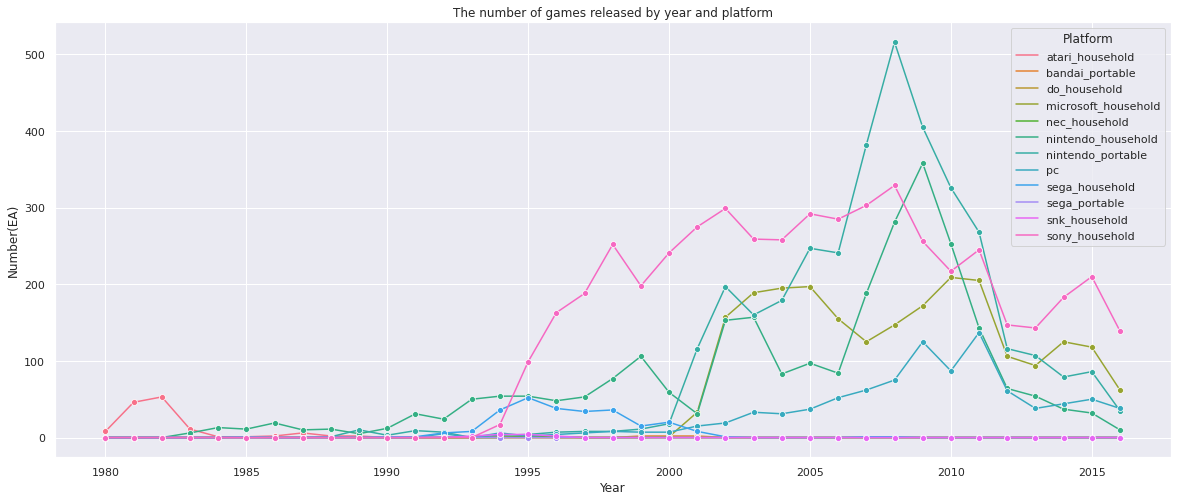

In [ ]:
nintendo_portable = ['DS', 'GBA', '3DS', 'GB']
nintendo_household = ['Wii', 'GC', 'NES', 'N64', 'SNES', 'WiiU']
sony_portable = ['PSP', 'PSV']
sony_household = ['PS3', 'PS', 'PS4', 'PS2']
pc = ['PC']
microsoft_household = ['XB', 'X360', 'XOne']
atari_household = ['2600']
sega_household = ['SAT', 'DC','GEN', 'SCD']
sega_portable = ['GG']
bandai_portable = ['WS']
snk_household = ['NG']
nec_household = ['TG16', 'PCFX']
do_household = ['3DO']

# # create a function to define platform2 groups
def Platform2(row):
  if row['Platform'] in nintendo_portable:
    return 'nintendo_portable'
  elif row['Platform'] in nintendo_household:
    return 'nintendo_household'
  elif row['Platform'] in sony_portable:
    pass
  elif row['Platform'] in sony_household:
    return 'sony_household'
  elif row['Platform'] in pc:
    return 'pc'
  elif row['Platform'] in microsoft_household:
    return 'microsoft_household'
  elif row['Platform'] in atari_household:
    return 'atari_household'
  elif row['Platform'] in sega_household:
    return 'sega_household'
  elif row['Platform'] in sega_portable:
    return 'sega_portable'
  elif row['Platform'] in bandai_portable:
    return 'bandai_portable'
  elif row['Platform'] in snk_household:
    return 'snk_household'
  elif row['Platform'] in nec_household:
    return 'nec_household'
  elif row['Platform'] in do_household:
    return 'do_household'

df_by_platform = df.copy()
# apply to dataframe, use axis=1 to apply the function to every row
df_by_platform['Platform2'] = df_by_platform.apply(Platform2, axis=1)
df_by_platform['Platform2'] = df_by_platform['Platform2'].astype('string')

df_by_platform = df_by_platform[['Name', 'Year', 'Platform2']].groupby(['Year', 'Platform2']).count()
df_by_platform = df_by_platform.reset_index(drop=False)

df_by_platform_wide = df_by_platform.pivot('Year', 'Platform2', 'Name')   # tidy -> wide
df_by_platform_wide = df_by_platform_wide.fillna(0)   # Missing values 0으로 대체
df_by_platform_wide = df_by_platform_wide.reset_index(drop=False)

for col in list(df_by_platform['Platform2'].unique()):   # 'Platform'별로 반복하면서 datatype을 int로 변환
  df_by_platform_wide[col].astype('int')

df_by_platform = df_by_platform_wide.melt(id_vars=['Year'], var_name='Platform', value_name='Number')   # wide -> tidy

fig3, ax3 = plt.subplots(figsize=(20,8))
ax3 = sns.lineplot(data=df_by_platform, x="Year", y="Number", hue="Platform", marker="o")
ax3.set_ylabel('Number(EA)')
ax3.set_title("The number of games released by year and platform")
plt.show()

 - 2007년 부터 2016년 까지 10년동안 플랫폼별 출시된 게임의 수 Top3?

In [ ]:
def print_top_p(y, top):
  col_top = df_by_platform[(df_by_platform['Year']==y)].nlargest(n=top, columns="Number").reset_index(drop=True)
  print('\n{:*^40}'.format(" Top%d Platform in %s " % (top, y)))
  for i in range(top):
    print('#{0} {1:^22} - {2:>12}'.format(i+1, col_top['Platform'][i], int(col_top['Number'][i])))

for yr in range(2007, 2017):
  print_top_p(yr, 3)


******** Top3 Platform in 2007 *********
#1   nintendo_portable    -          382
#2     sony_household     -          303
#3   nintendo_household   -          188

******** Top3 Platform in 2008 *********
#1   nintendo_portable    -          516
#2     sony_household     -          329
#3   nintendo_household   -          281

******** Top3 Platform in 2009 *********
#1   nintendo_portable    -          405
#2   nintendo_household   -          358
#3     sony_household     -          256

******** Top3 Platform in 2010 *********
#1   nintendo_portable    -          326
#2   nintendo_household   -          253
#3     sony_household     -          217

******** Top3 Platform in 2011 *********
#1   nintendo_portable    -          268
#2     sony_household     -          245
#3  microsoft_household   -          205

******** Top3 Platform in 2012 *********
#1     sony_household     -          147
#2   nintendo_portable    -          116
#3  microsoft_household   -          106

******** 

- 통계적으로 최근 10년동안 플랫폼별 출시 게임 비율이 다를까?
 - Chi square test
 - H0 : 두 변수(연도와 플랫폼별 출시 게임 수)는 독립적이다. (independence) (비율이 같다.)
 - Ha : 두 변수(연도와 플랫폼별 출시 게임 수)는 독립적이지 않다. (related) (비율이 같지 않다.)
 - α : 0.05

In [ ]:
df_by_platform_10 = df_by_platform_wide[(df_by_platform_wide['Year']<=2016) & (df_by_platform_wide['Year']>=2007)]
df_by_platform_10 = df_by_platform_10.reset_index(drop=True)
obs3 = np.array(df_by_platform_10[['microsoft_household', 'nintendo_household', 'nintendo_portable', 'pc', 'sega_household', 'sony_household']])
obs3 = obs3.astype(int)
g3, p3, dof3, expctd3 = chi2_contingency(obs3)
if p3 < 0.05:
  print("Reject the Null hypothesis!")
  print("통계적으로 연도에 따른 출시되는 플랫폼 비율은 유의하다.(같지 않다.)")
else:
  print("Failure to reject the Null hypothesis!")
  print("통계적으로 연도에 따른 출시되는 플랫폼 비율은 유의하지 않다.(같다.)")

Reject the Null hypothesis!
통계적으로 연도에 따른 출시되는 플랫폼 비율은 유의하다.(같지 않다.)


- 'Platform'을 분석하다보니 'Platform'별로 (휴대용 가정용) 구분이 가능했다. 그렇다면, 연도별 (휴대용 가정용)에 따른 출시된 게임의 수는 어떨까?

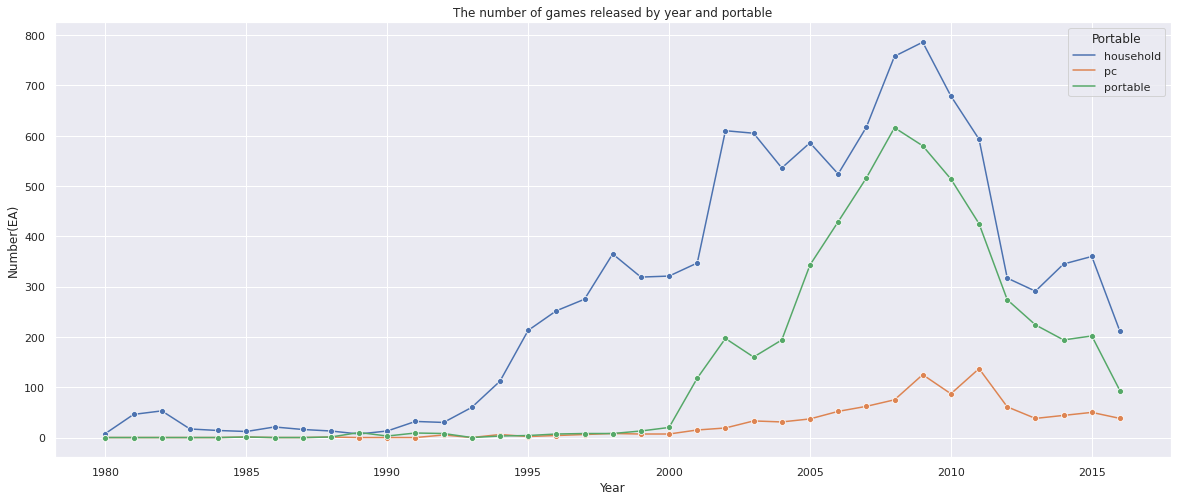

In [ ]:
portable = ['DS', 'PSP', 'GBA', '3DS', 'GB', 'PSV', 'WS', 'GG']
household = ['Wii', 'PS3', 'PS', 'PS4', 'PS2', 'XB', 'X360', 'GC', '2600', 'SAT', 'NES', 'DC', 'N64', 'XOne', 'SNES', 'WiiU', 'GEN', 'SCD', 'NG', 'TG16', '3DO', 'PCFX']
pc = ['PC']
df_portable = df.copy()

# create a function to define portable groups
def Portable(row):
  if row['Platform'] in portable:
    return 'portable'
  elif row['Platform'] in household:
    return 'household'
  elif row['Platform'] in pc:
    return 'pc'

# apply to dataframe, use axis=1 to apply the function to every row
df_portable['Portable'] = df_portable.apply(Portable, axis=1)
df_portable['Portable'] = df_portable['Portable'].astype('string')

df_portable_by_year = df_portable[['Name', 'Year', 'Portable']].groupby(['Year', 'Portable']).count()
df_portable_by_year = df_portable_by_year.reset_index(drop=False)

df_portable_by_year_wide = df_portable_by_year.pivot('Year', 'Portable', 'Name')   # tidy -> wide
df_portable_by_year_wide = df_portable_by_year_wide.fillna(0)   # Missing values 0으로 대체
df_portable_by_year_wide = df_portable_by_year_wide.reset_index(drop=False)

for col in ['household', 'pc', 'portable']:   # 'Portable'별로 반복하면서 datatype을 int로 변환
  df_portable_by_year_wide[col].astype('int')

df_portable_by_year = df_portable_by_year_wide.melt(id_vars=['Year'], var_name='Portable', value_name='Number')   # wide -> tidy

fig4, ax4 = plt.subplots(figsize=(20,8))
ax4 = sns.lineplot(data=df_portable_by_year, x="Year", y="Number", hue="Portable", marker="o")
ax4.set_ylabel('Number(EA)')
ax4.set_title("The number of games released by year and portable")
plt.show()

- 통계적으로 최근 10년동안 플랫폼 종류별 출시 게임 비율이 다를까?
 - Chi square test
 - H0 : 두 변수(연도와 플랫폼 종류별 출시 게임 수)는 독립적이다. (independence) (비율이 같다.)
 - Ha : 두 변수(연도와 플랫폼 종류별 출시 게임 수)는 독립적이지 않다. (related) (비율이 같지 않다.)
 - α : 0.05

In [ ]:
df_portable_by_year_10 = df_portable_by_year_wide[(df_portable_by_year_wide['Year']<=2016) & (df_portable_by_year['Year']>=2007)]
df_portable_by_year_10 = df_portable_by_year_10.reset_index(drop=True)
obs4 = np.array(df_portable_by_year_10[['household', 'portable', 'pc']])
obs4 = obs4.astype(int)
g4, p4, dof4, expctd4 = chi2_contingency(obs4)
if p4 < 0.05:
  print("Rejecrt the Null hypothesis!")
  print("통계적으로 연도에 따른 출시되는 플랫폼 종류 비율은 유의하다.(같지 않다.)")
else:
  print("Failure to reject the NUll hypothesis!")
  print("통계적으로 연도에 따른 출시되는 플랫폼 종류 비율은 유의하지 않다.(같다.)")

Rejecrt the Null hypothesis!
통계적으로 연도에 따른 출시되는 플랫폼 종류 비율은 유의하다.(같지 않다.)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스
 - 출고량이 높은 게임 Top3에 해당하는 rows들을 select
 - 출고량이 높은 게임 Top3에 해당하는 rows들을 'Region'에 따라 시각화


************** Top3 Game ***************

#1        Wii Sports         -    82.74M
  Platform  - Wii
  Year      - 2006
  Genre     - Sports
  Publisher - Nintendo
----------------------------------------

#2     Super Mario Bros.     -    40.24M
  Platform  - NES
  Year      - 1985
  Genre     - Platform
  Publisher - Nintendo
----------------------------------------

#3      Mario Kart Wii       -    35.83M
  Platform  - Wii
  Year      - 2008
  Genre     - Racing
  Publisher - Nintendo
----------------------------------------


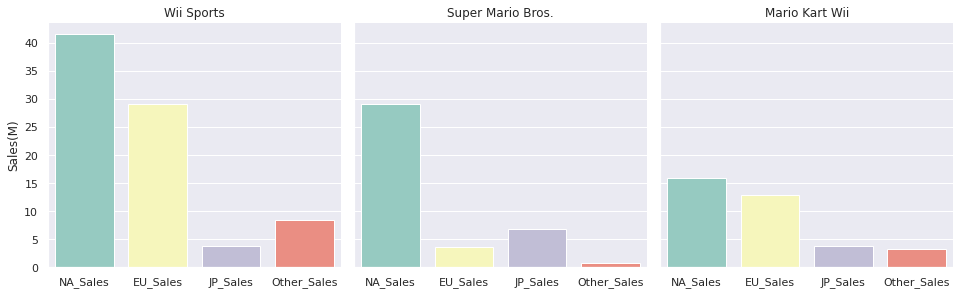

In [ ]:
def print_top_s(top):
  col_top = df_a.nlargest(n=top, columns="Total_Sales").reset_index(drop=True)
  print('\n{:*^40}'.format(" Top%d Game " % (top)))
  for i in range(top):
    print('\n#{0} {1:^25} - {2:>8.2f}M'.format(i+1, col_top['Name'][i], col_top['Total_Sales'][i]))
    print('  Platform  - {0}'.format(col_top['Platform'][i]))
    print('  Year      - {0}'.format(col_top['Year'][i]))
    print('  Genre     - {0}'.format(col_top['Genre'][i]))
    print('  Publisher - {0}'.format(col_top['Publisher'][i]))
    print("-"*40)

df_a = df.copy()
df_a['Total_Sales'] = df_a[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis=1)

print_top_s(3)

df_a_top3 = df_a.nlargest(n=3, columns="Total_Sales").reset_index(drop=True)
melt_df_a_top3 = df_a_top3.melt(id_vars=["Name"], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], var_name="Region", value_name="Sales")   # FacetGrid를 그리기위해 wide -> tidy

g2 = sns.FacetGrid(melt_df_a_top3, col="Name", height=4.5)
g2.map(sns.barplot, "Region", "Sales", palette="Set3", order=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
g2.set_axis_labels("", "Sales(M)")
g2.set_titles(col_template="{col_name}")
plt.show()